In [1]:
# Importerer pakker:
import numpy as np
from diabetessims import *

Initializes patients, and meals. Finds optimal bolus for each meal.

# Simulation

In [126]:
t = 1
meals = np.array([[50, 6,6.25], [20, 10, 10.25], [100, 12.5, 12.75], [20, 15, 15.25], [100, 18.5, 18.75], [20, 21, 21.25]])

res = []
p0 = baseline_patient(0, model = "HM", timestep = t, n_pancreas = 20)
p1 = baseline_patient(1, model = "HM", timestep = t)
p2 = baseline_patient(2, model = "HM", timestep = t, n_pancreas = 20)

res1 = p1.plan_treatment(meals)
res2 = p2.plan_treatment(meals)
meal_arr = timestamp_arr(meals, t)
info_normal = p0.simulate(ds = meal_arr)

- Måltider
- Bolus
- Pid param
- Penalty før og efter (begge to)
- Histogram, før og efter

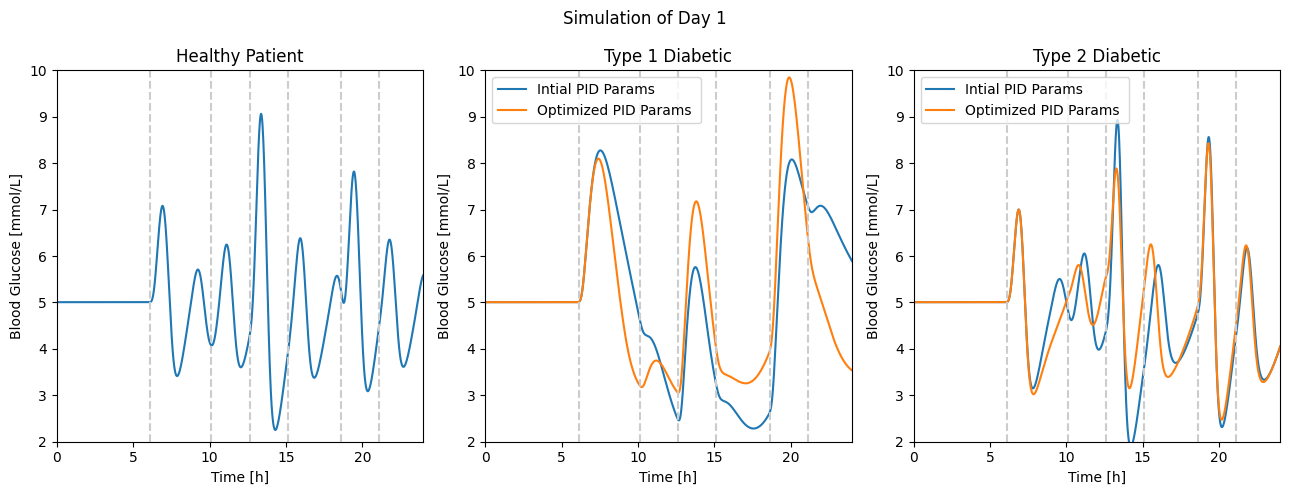

In [173]:
fig, ax = plt.subplots(1, 3, figsize = (13, 5))
t = res1[1]["t"]/60
fig.suptitle("Simulation of Day 1")
ax[0].set_title("Healthy Patient")
ax[0].plot(t, info_normal["G"])
ax[1].set_title("Type 1 Diabetic")
ax[1].plot(t, res1[1]["G"],  label = "Intial PID Params ")
ax[1].plot(t, res1[2]["G"],  label = "Optimized PID Params ")

ax[2].set_title("Type 2 Diabetic")
ax[2].plot(t, res2[1]["G"], label = "Intial PID Params ")
ax[2].plot(t, res2[2]["G"], label = "Optimized PID Params ")
for i in range(3):
    ax[i].set_xlabel("Time [h]")
    ax[i].set_ylabel("Blood Glucose [mmol/L]")
    ax[i].set_ylim(2, 10)
    ax[i].set_xlim(0, 24)
    for j in range(len(meals)):
        ts = meals[j][1:].mean()
        ax[i].axvline(ts, color="#ccc", linestyle="--")
    
ax[1].legend()
ax[2].legend()
fig.tight_layout()

In [2]:
t = 1
pHM0 = baseline_patient(0, model = "HM", timestep=t, n_pancreas = 20)
pHM1 = baseline_patient(1, model = "HM", timestep=t)
pHM2 = baseline_patient(2, model = "HM", timestep=t, n_pancreas = 20)

meals1 = np.array([[50, 6,6.25], [20, 10, 10.25], [100, 12.5, 12.75], [20, 15, 15.25], [100, 18.5, 18.75], [20, 21, 21.25]])
meals2 = np.array([[100, 6,6.25], [100, 12.5, 12.75], [100, 18.5, 18.75]])
meals3 = np.array([[50, 7.5,7.75], [20, 10, 10.25], [20, 15, 15.25], [70, 18.5, 18.75], [20, 21, 21.25]])
meals4 = np.array([[50, 6,6.25], [20, 10, 10.25], [20, 15, 15.25], [70, 18.5, 18.75], [20, 21, 21.25]])
meals5 = np.array([[20, 9, 9.25], [20, 10, 10.25], [40, 15, 15.25], [100, 18.5, 18.75], [70, 21, 21.25]])
pid_keys =  ["Kp", "Ti", "Td"]
params = [0.5, 500, 25]

meals = [meals1,meals2, meals3, meals4, meals5]
res0 = []
res1 = []
res2 = []
for i,m in enumerate(meals):
    for i,k in enumerate(pid_keys):
        setattr(pHM1.pumpObj, k, params[i])
        setattr(pHM2.pumpObj, k, params[i])
    res1.append(pHM1.plan_treatment(m))
    res2.append(pHM2.plan_treatment(m))

In [10]:
res1[0][3]

  message: Desired error not necessarily achieved due to precision loss.
  success: False
   status: 2
      fun: 559221.2252295166
        x: [-1.971e-02  1.982e+01 -5.865e+03]
      nit: 509
      jac: [-1.559e+05 -1.445e+02  9.375e-02]
 hess_inv: [[ 9.162e-12 -9.191e-10  1.326e-10]
            [-9.191e-10  6.099e-07 -8.726e-08]
            [ 1.326e-10 -8.726e-08  1.387e-08]]
     nfev: 4337
     njev: 1082

In [30]:
res_dict1 = {}
res_dict2 = {}
res_dict = {}
for j, r in enumerate([res1, res2]):
    res_dict[j] = []
    for i in range(5):
        res_dict[j].append({ "meals" : meals[i],
            "bolus" : r[i][0],
            "info0" : r[i][1],
            "info1" : r[i][2],
            "opt_res" : r[i][3]
        })

In [44]:
def generate_table(meals, bolus):
    bolus = bolus.T
    start = meals[:, 1] 
    end = meals[:, 2]
    n = 3
    if bolus.ndim == 2:
        n += bolus.shape[1] - 1
    inner = "Time & Meal size (g) & Bolus Size (mU) \\\\ \\hline \n"
    for m,b in zip(meals, bolus):
        start, end = [f"{str(int(m[i+1])).zfill(2)}:{str(int(60*(m[i+1]%1))).zfill(2)}" for i in range(2)]
        row1 = f"{start}-{end} & {int(m[0])} "
        if bolus.ndim == 2:
            row2 = "".join([f"& {int(b[i])} "  for i in range(n-2)]) 
        else:
            row2 = f"% {int(b)}"
        row3 = "\\\\ \\hline \n"
        inner += row1 + row2 + row3
    return "\\begin{table}[]\n\\begin{tabular}{|"+"".join(["r|" for i in range(n)])+"}\\hline \n"+inner+"\\end{tabular}\n\\end{table}"



In [45]:
for i in range(5):
    bolus = np.vstack([res_dict[k][i]["bolus"][:, 0] for k in range(2)])
    print(generate_table(meals[i], bolus))

\begin{table}[]
\begin{tabular}{|r|r|r|r|}\hline 
Time & Meal size (g) & Bolus Size (mU) \\ \hline 
06:00-06:15 & 50 & 1497 & 113 \\ \hline 
10:00-10:15 & 20 & 860 & -1 \\ \hline 
12:30-12:45 & 100 & 3023 & -376 \\ \hline 
15:00-15:15 & 20 & 860 & 1312 \\ \hline 
18:30-18:45 & 100 & 3023 & -518 \\ \hline 
21:00-21:15 & 20 & 860 & 1312 \\ \hline 
\end{tabular}
\end{table}
\begin{table}[]
\begin{tabular}{|r|r|r|r|}\hline 
Time & Meal size (g) & Bolus Size (mU) \\ \hline 
06:00-06:15 & 100 & 3023 & 529 \\ \hline 
12:30-12:45 & 100 & 3023 & -517 \\ \hline 
18:30-18:45 & 100 & 3023 & -517 \\ \hline 
\end{tabular}
\end{table}
\begin{table}[]
\begin{tabular}{|r|r|r|r|}\hline 
Time & Meal size (g) & Bolus Size (mU) \\ \hline 
07:30-07:45 & 50 & 1497 & 113 \\ \hline 
10:00-10:15 & 20 & 860 & -1 \\ \hline 
15:00-15:15 & 20 & 860 & -354 \\ \hline 
18:30-18:45 & 70 & 1947 & -378 \\ \hline 
21:00-21:15 & 20 & 860 & 1257 \\ \hline 
\end{tabular}
\end{table}
\begin{table}[]
\begin{tabular}{|r|r|r|r|}

In [84]:
for k in range(2):
    print(r"\begin{table}[H]")
    print(r"\begin{tabular}{|r|r|r|r|}\hline")
    print(r"Day & Penalty Before PID Optimization & Penalty After PID Optimization & Kp & Ti & Td \\ ")
    arr = (np.array([np.append(np.array(["{:.3e}".format(res_dict[k][i][f"info{t}"]["pens"].sum()) for t in range(2)]), res_dict[k][i]["opt_res"].x)  for i in range(5)]))
    for i,row in enumerate(arr):
        print(f"{i+1} & " + " & ".join([str(entry) for entry in row]) + r"\\")
    print(r"\end{tabular}")
    print(r"\end{table}")

\begin{table}[H]
\begin{tabular}{|r|r|r|r|}\hline
Day & Penalty Before PID Optimization & Penalty After PID Optimization & Kp & Ti & Td \\ 
1 & 1.911e+11 & 5.592e+05 & -0.019714780518116128 & 19.817871089631293 & -5865.132340446283\\
2 & 1.231e+11 & 8.990e+05 & -0.13271284368500535 & 799.0745077822021 & 391.6591451555042\\
3 & 2.711e+09 & 2.487e+05 & 0.040442401270021355 & 21.53331614655348 & 4867.439060195569\\
4 & 6.472e+08 & 2.685e+05 & -0.10678429672434762 & 10097.142318320006 & -2214.3597315415172\\
5 & 5.444e+08 & 2.136e+05 & -0.21567943300290324 & 6132.121973309498 & -703.4419657499255\\
\end{tabular}
\end{table}
\begin{table}[H]
\begin{tabular}{|r|r|r|r|}\hline
Day & Penalty Before PID Optimization & Penalty After PID Optimization & Kp & Ti & Td \\ 
1 & 5.094e+11 & 3.191e+11 & -1.9501425635142164 & 23446.53321692605 & 82.09318112932603\\
2 & 4.412e+11 & 4.006e+11 & -3.0481724180033885 & 2023.9733346081719 & -5.656903447316034\\
3 & 1.541e+11 & 5.694e+10 & 6.77148542335779 & 140

In [3]:

with open("res1.json", "w") as outfile: 
    json.dump(res1, outfile)
with open("res2.json", "w") as outfile: 
    json.dump(res2, outfile)

TypeError: Object of type ndarray is not JSON serializable

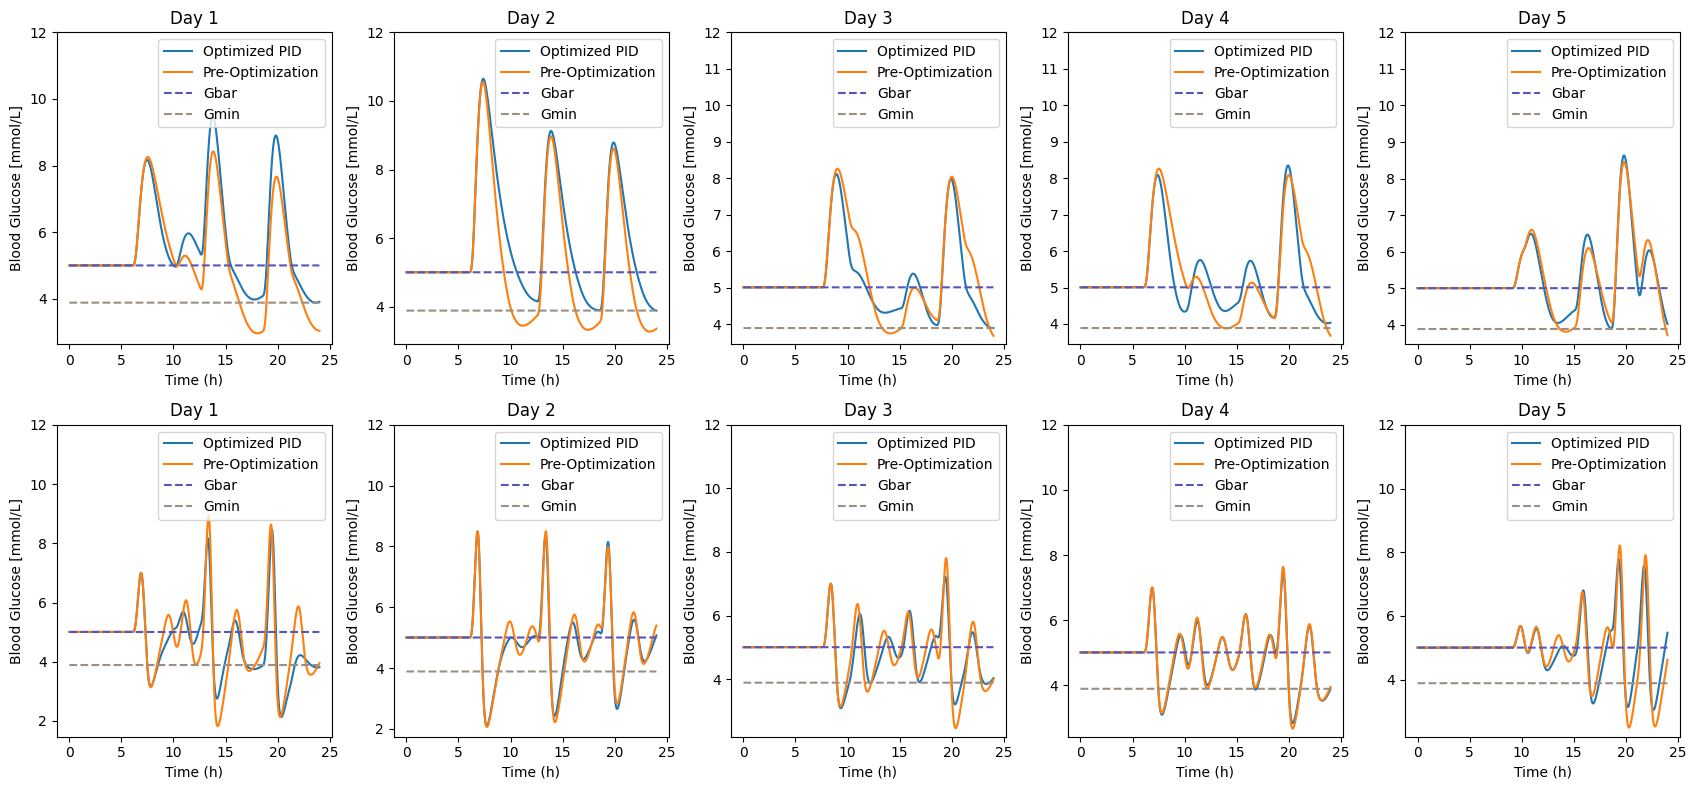

In [88]:
n_patients = 2
fig, ax = plt.subplots(n_patients, len(meals), figsize=(17, 8))
r = [res1, res2]
for i in range(len(meals)):
    for k in range(n_patients):        
        bolus, info, info_opt, opt = r[k][i]
        j = i * n_patients + k
        ax[k,i].plot(info_opt["t"]/60, info_opt["G"], label="Optimized PID")
        ax[k,i].plot(info["t"]/60, info["G"], label="Pre-Optimization")
        ax[k,i].set_title(f"Day {i+1}")
        ax[k,i].set_xlabel("Time (h)")
        ax[k,i].set_ylabel("Blood Glucose [mmol/L]")
        ax[k, i].set_ylim(top=12)
        ax[k, i].plot(info["t"]/60,np.ones(len(info["t"]))*info["G"][0], "--",color="#5555BB", label= "Gbar")
        ax[k, i].plot(info["t"]/60,np.ones(len(info["t"]))*3.889, "--",color="#998F85", label= "Gmin")
        ax[k,i].legend()

fig.tight_layout()
plt.show()

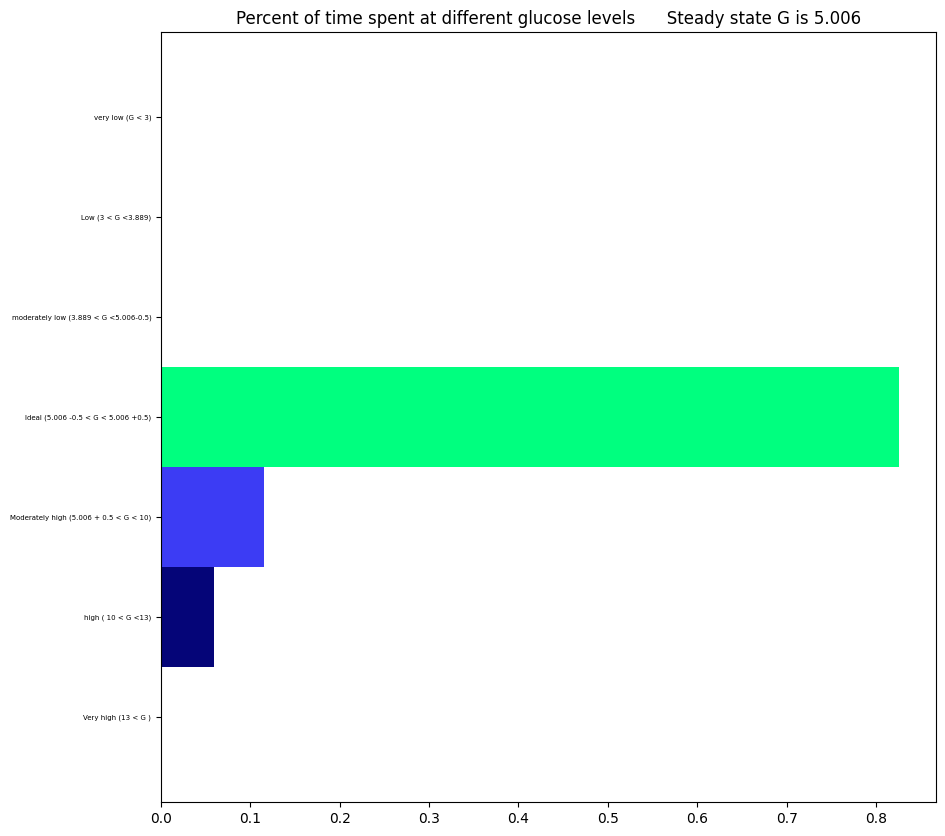

In [105]:
pHM0.hist(res_dict[0][4]["info0"]["G"])

In [ ]:

meals = np.array([[50, 6,6.25], [20, 10, 10.25], [100, 12.5, 12.75], [20, 15, 15.25], [100, 18.5, 18.75], [20, 21, 21.25]])
meal_arr = timestamp_arr(meals, t, fill = 0)

bolus1 = []
bolus2 = []
for m in meals:
    u1, phi, p, Gt = p_EHMT1.meal_bolus(m[0], max_U = 5000, n = 100)
    u2, phi, p, Gt = p_EHMT2.meal_bolus(m[0], max_U = 500, n = 100)

    bolus1.append([u1,m[1]])
    bolus2.append([u2,m[1]])

bolus1 = np.array(bolus1)
bolus2 = np.array(bolus2)


In [ ]:
bolus1_arr = timestamp_arr(bolus1, t, fill = None)
bolus2_arr = timestamp_arr(bolus2, t, fill = None)

info0 = p_EHM0.simulate(ds = meal_arr)
info1 = p_EHMT1.simulate(ds = meal_arr, uIs = bolus1_arr)
info2 = p_EHMT2.simulate(ds = meal_arr, uIs = bolus2_arr)

filter_u(info1)
filter_u(info2)

bolus = np.vstack([bolus1[:,0],bolus2[:,1]])
print(generate_table(meals, bolus))


[[1969.6969697   707.07070707 3030.3030303   707.07070707 3030.3030303
   707.07070707]
 [   6.           10.           12.5          15.           18.5
    21.        ]]
\begin{table}[]
\begin{tabular}{|r|r|r|r|}\hline 
Time & Meal & Bolus Size \\ \hline 
06:00-06:15 & 50 & 1969 & 6 \\ \hline 
10:00-10:15 & 20 & 707 & 10 \\ \hline 
12:30-12:45 & 100 & 3030 & 12 \\ \hline 
15:00-15:15 & 20 & 707 & 15 \\ \hline 
18:30-18:45 & 100 & 3030 & 18 \\ \hline 
21:00-21:15 & 20 & 707 & 21 \\ \hline 
\end{tabular}
\end{table}


In [ ]:
opt1 = optimize_pid(p_EHMT1, meal_arr, bolus1_arr)
opt2 = optimize_pid(p_EHMT2, meal_arr, bolus2_arr)

In [ ]:
info1_opt = p_EHMT1.simulate(ds = meal_arr, uIs = bolus1_arr)
info2_opt = p_EHMT2.simulate(ds = meal_arr, uIs = bolus2_arr)


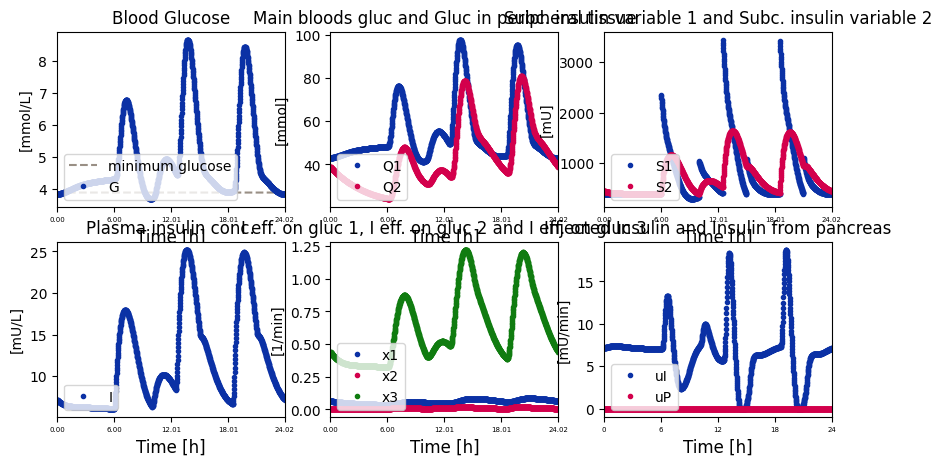

In [ ]:
filter_u(info1_opt)
filter_u(info2_opt)

p_EHMT1.statePlot(info1_opt, (2,3), (10, 5), [["G"],["Q1", "Q2"], ["S1", "S2"], ["I"], ["x1", "x2", "x3"], ["uI", "uP"]], 12)

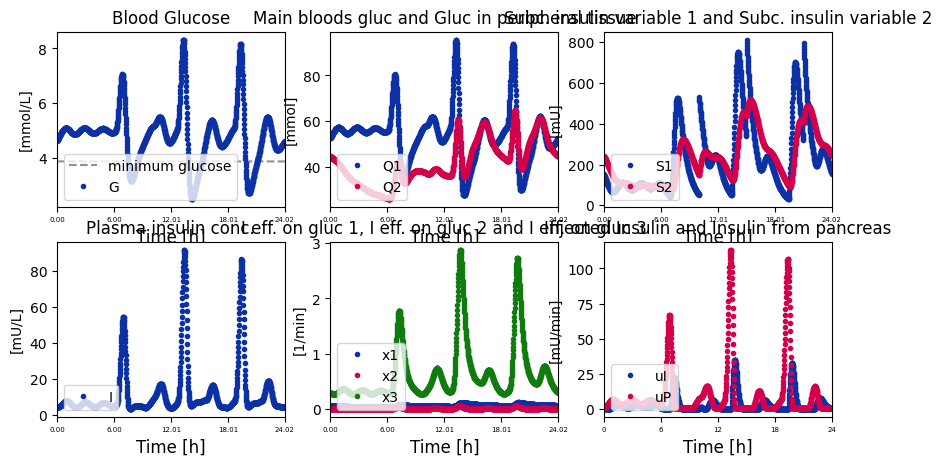

In [ ]:
p_EHMT2.statePlot(info2_opt, (2,3), (10, 5), [["G"],["Q1", "Q2"], ["S1", "S2"], ["I"], ["x1", "x2", "x3"], ["uI", "uP"]], 12)

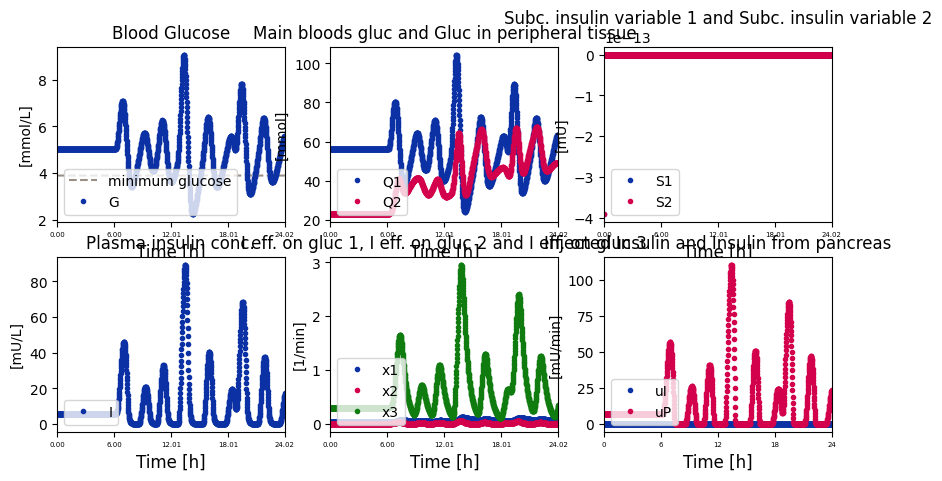

In [ ]:
p_EHM0.statePlot(info0, (2,3), (10, 5), [["G"],["Q1", "Q2"], ["S1", "S2"], ["I"], ["x1", "x2", "x3"], ["uI", "uP"]], 12)

In [ ]:
print("Penalty")
def format_e(n):
    a = '%E' % n
    return a.split('E')[0].rstrip('0').rstrip('.') + 'E' + a.split('E')[1]

print(info0["pens"].sum())
print(info1["pens"].sum())
print(info1_opt["pens"].sum())
print(info2["pens"].sum())
print(info2_opt["pens"].sum())

Penalty
201039185782.70746
20085306881.491295
2679744362.2140746
355822259741.98004
207929570457.18878


# Optimal Bolus

In [ ]:
# Importerer pakker:
from diabetessims.extendedmodel import *
from diabetessims.utils import *
from diabetessims.pancreas import *
import numpy as np
import matplotlib.pyplot as plt
from pprint import pprint

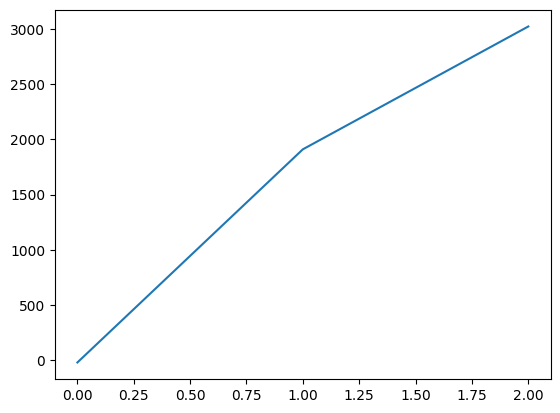

In [ ]:
t = 1
from scipy.optimize import minimize_scalar
p = baseline_patient(1, model = "HM", timestep=t)
def best_bolus(patient, meal_size, meal_idx = 0, iterations = None):
    if iterations == None:
        iterations = int(24 * 60 / patient.timestep)
    def cost(u):
        phi, _, _ = patient.bolus_sim(u, meal_size, meal_idx, iterations)
        return phi
    return minimize_scalar(cost, tol=1e-10)
pat = baseline_patient(1, model = "HM", timestep=t)

phis = []
def best_bolus(patient, meal_size, h = 24, max_bolus = 10000, splits = 10):
    if isinstance(meal_size, (np.ndarray, list)):
        return np.array([best_bolus(patient, meal_size=m, h = h) for m in meal_size])
    # broad and rough search for minima
    iterations = int(h * 60 / patient.timestep)
    us = np.linspace(0, max_bolus, splits)
    phis = []
    for u in us:
        phi, _, _ = patient.bolus_sim(u, meal_size = meal_size, iterations = iterations)
        phis.append(phi)
    u0 = us[np.argmin(phis)]
    def cost(u):
        phi, _, _ = patient.bolus_sim(u, meal_size = meal_size, iterations = iterations)
        return phi
    return minimize_scalar(cost, bounds=[u0 - max_bolus/splits, u0 + max_bolus/splits]).x

u = best_bolus(pat, np.arange(0, 150, 50))
plt.plot(u)
#phi, p, Gt = pat.bolus_sim(res, 40, iterations = int(24 * 60 / pat.timestep))
#print(phi)
#plt.plot(Gt)
#plt.semilogy(us, phis)


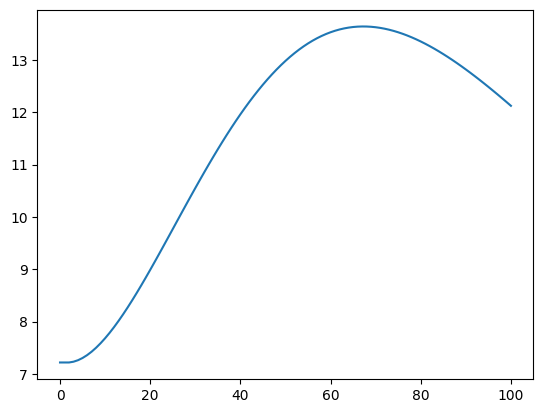

In [ ]:
patmvp = baseline_patient(1, model = "MVP", timestep=t)
phi, p, G = patmvp.bolus_sim(10000, 150)
plt.plot(G)

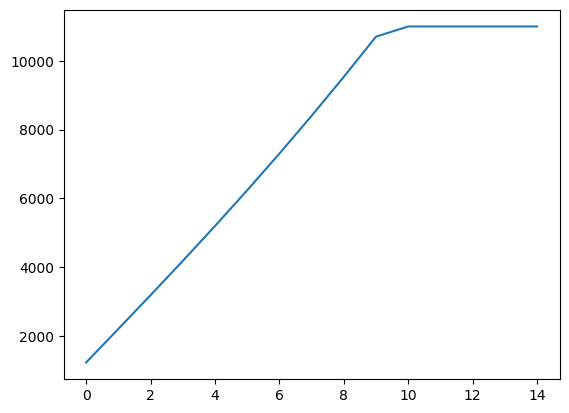

In [ ]:
patmvp = baseline_patient(1, model = "MVP", timestep=t)
u = best_bolus(patmvp, np.arange(0, 150, 10))
plt.plot(u)

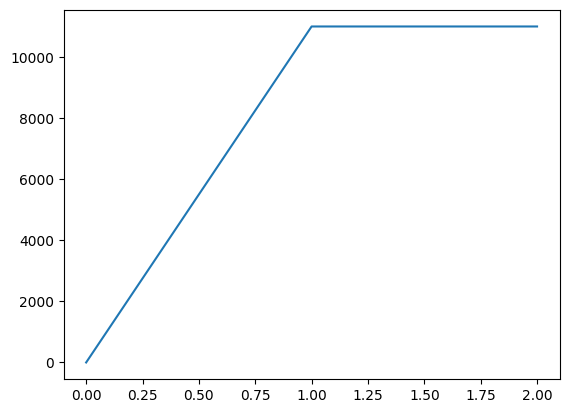

In [ ]:
patmvp = baseline_patient(1, model = "MVP", timestep=t)
umvp = best_bolus(patmvp, np.arange(0,150,50), max_bolus = 8*10000)
plt.plot(umvp)

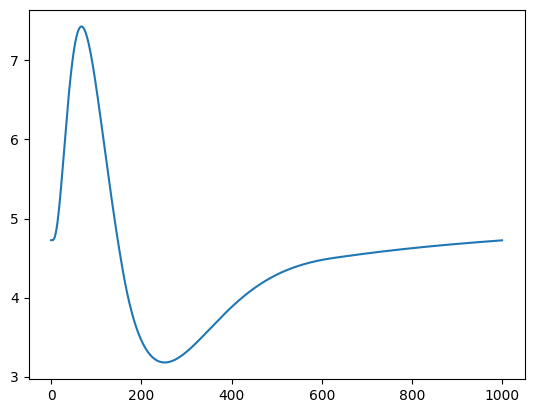

In [ ]:
plt.plot(Gt)